In [1]:
# Acknowledgment : I followed the tutorial to implement this text classification code: https://www.kaggle.com/code/benroshan/sentiment-analysis-amazon-reviews

#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE
from textblob import Word, TextBlob

In [2]:
raw_reviews = pd.read_csv('Flipkart_Reviews - Electronics.csv')
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(9374, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9374 entries, 0 to 9373
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     9374 non-null   object
 1   product_title  9374 non-null   object
 2   rating         9374 non-null   int64 
 3   summary        9374 non-null   object
 4   review         9374 non-null   object
 5   location       8081 non-null   object
 6   date           9374 non-null   object
 7   upvotes        9374 non-null   int64 
 8   downvotes      9374 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 659.2+ KB
None


In [3]:
raw_reviews.head()

product_id                                      product_title  \
0  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
1  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
2  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
3  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
4  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   

   rating            summary  \
0       5  Terrific purchase   
1       5  Terrific purchase   
2       5             Super!   
3       5             Super!   
4       5  Terrific purchase   

                                              review       location  \
0  1-more flexible2-bass is very high3-sound clar...        Shirala   
1     Super sound and good looking I like that prize  Visakhapatnam   
2  Very much satisfied with the device at this pr...      Kozhikode   
3  Nice headphone, bass was very good and sound i...          Jaora   
4  Sound quality super battery backup super quali...      New Delhi   

           date  upvotes  downvotes  
0  8 months ago     1390        276  
1  8 months ago      643        133  
2     Feb, 2020     1449        328  
3  7 months ago      160         28  
4  8 months ago      533        114

## Data Preprocessing and Data Cleaning

Handling NaN values


In [4]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

product_id          0
product_title       0
rating              0
summary             0
review              0
location         1293
date                0
upvotes             0
downvotes           0
dtype: int64

####  No NaN values in both summary and review section. These are the two columns we will be focusing here.

## Concatenating the columns - review text and summary
Combining the review text and summary column.

In [5]:
process_reviews['reviews']= process_reviews['review'] + process_reviews['summary']
process_reviews = process_reviews.drop(['review', 'summary'], axis=1)

process_reviews.head()

product_id                                      product_title  \
0  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
1  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
2  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
3  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
4  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   

   rating       location          date  upvotes  downvotes  \
0       5        Shirala  8 months ago     1390        276   
1       5  Visakhapatnam  8 months ago      643        133   
2       5      Kozhikode     Feb, 2020     1449        328   
3       5          Jaora  7 months ago      160         28   
4       5      New Delhi  8 months ago      533        114   

                                             reviews  
0  1-more flexible2-bass is very high3-sound clar...  
1  Super sound and good looking I like that prize...  
2  Very much satisfied with the device at this pr...  
3  Nice headphone, bass was very good and sound i...  
4  Sound quality super battery backup super quali...

In [6]:
process_reviews['reviews'][0]

"1-more flexible2-bass is very high3-sound clarity is good 4-battery back up to 6 to 8 hour's 5-main thing is fastest charging system is available in that. Only 20 min charge and get long up to 4 hours back up 6-killing look awesome 7-for gaming that product does not support 100% if you want for gaming then I'll recommend you please don't buy but you want for only music then this product is very well for you.. 8-no more wireless headphones are comparing with that headphones at this pric...Terrific purchase"

## Analyzing the 'sentiment' of the reviews

In this step, we will create the outcome column - which indicates the sentiment of a review. We make use of the rating to arive at this decision. 
If the rating is greater than 3, we take that as positive and if the rating is less than 3 it is negative. If it is equal to 3, we take that as neutral sentiment

In [7]:
#Figuring out the distribution of categories
process_reviews['rating'].value_counts()

5    5395
4    1959
1    1090
3     622
2     308
Name: rating, dtype: int64

In [8]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['rating'] == 3.0:
        val = 'Neutral'
    elif row['rating'] == 1.0 or row['rating'] == 2.0:
        val = 'Negative'
    elif row['rating'] == 4.0 or row['rating'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [9]:
#Applying the function - to obtain the sentiment column

process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

product_id                                      product_title  \
0  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
1  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
2  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
3  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
4  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   

   rating       location          date  upvotes  downvotes  \
0       5        Shirala  8 months ago     1390        276   
1       5  Visakhapatnam  8 months ago      643        133   
2       5      Kozhikode     Feb, 2020     1449        328   
3       5          Jaora  7 months ago      160         28   
4       5      New Delhi  8 months ago      533        114   

                                             reviews sentiment  
0  1-more flexible2-bass is very high3-sound clar...  Positive  
1  Super sound and good looking I like that prize...  Positive  
2  Very much satisfied with the device at this pr...  Positive  
3  Nice headphone, bass was very good and sound i...  Positive  
4  Sound quality super battery backup super quali...  Positive

In [10]:
process_reviews['sentiment'].value_counts()

Positive    7354
Negative    1398
Neutral      622
Name: sentiment, dtype: int64

## Text Processing

In this section, we will process the review text - to remove all unwanted characters, numbers, and punctuations from the reviews.


In [11]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

product_id                                      product_title  \
0  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
1  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
2  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
3  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
4  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   

   rating       location          date  upvotes  downvotes  \
0       5        Shirala  8 months ago     1390        276   
1       5  Visakhapatnam  8 months ago      643        133   
2       5      Kozhikode     Feb, 2020     1449        328   
3       5          Jaora  7 months ago      160         28   
4       5      New Delhi  8 months ago      533        114   

                                             reviews sentiment  
0    is very  clarity is good  back up to  to  ho...  Positive  
1  super sound and good looking i like that prize...  Positive  
2  very much satisfied with the device at this pr...  Positive  
3  nice headphone bass was very good and sound is...  Positive  
4  sound quality super battery backup super quali...  Positive

##### We have removed all punctuation in our reviews column

## Stop words removal - from the reviews

Removal of stop words from the review text. Stopwords - such as "a", "is", "the", "and" etc. It also contains words like - "not","hasn't", "wouldn't" - but we will not remove such negative words, because in this case they actually contribute the negative sentiment. So we will foucs only on the stp words which doens't have negative words.


In [13]:
stop_words= stopwords.words('english')

process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

product_id                                      product_title  \
0  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
1  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
2  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
3  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
4  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   

   rating       location          date  upvotes  downvotes  \
0       5        Shirala  8 months ago     1390        276   
1       5  Visakhapatnam  8 months ago      643        133   
2       5      Kozhikode     Feb, 2020     1449        328   
3       5          Jaora  7 months ago      160         28   
4       5      New Delhi  8 months ago      533        114   

                                             reviews sentiment  
0  clarity good back hours thing fastest charging...  Positive  
1  super sound good looking like prizeterrific pu...  Positive  
2  much satisfied device price point awesome bran...  Positive  
3  nice headphone bass good sound clear purchase ...  Positive  
4  sound quality super battery backup super quali...  Positive

#### We have removed all the stop words in the review column

### Visualization from reviews

In this section, we will visualize the the relationship between the sentiment and other factors such as upvotes and downvotes

### Sentiments vs Upvotes
First lets look whether there any relationship between sentiment of review and upvotes of it

In [14]:
pd.DataFrame(process_reviews.groupby('sentiment')['upvotes'].mean())

upvotes
sentiment          
Negative   4.061516
Neutral    2.437299
Positive   9.350150

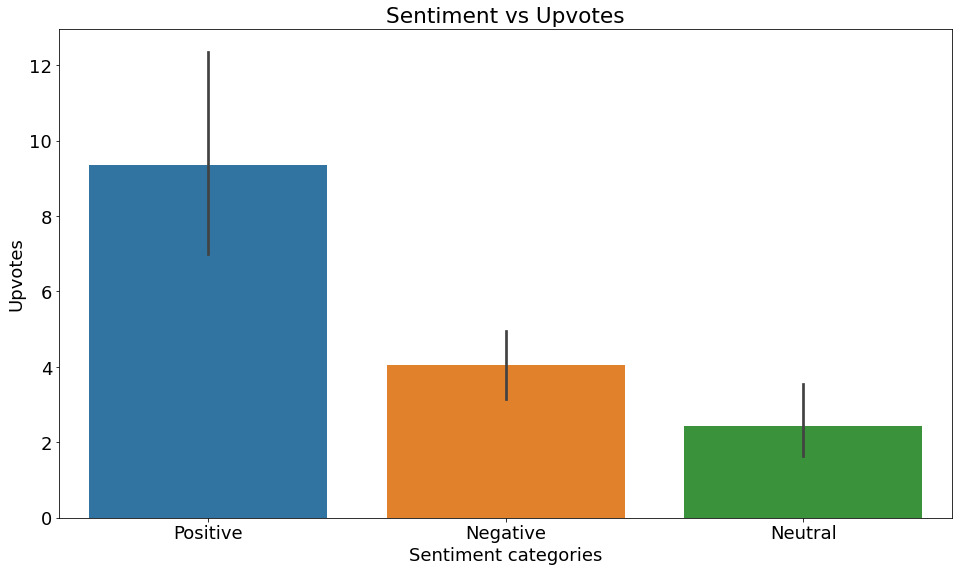

In [15]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'upvotes'])


#Plotting phase
sns.barplot( x=senti_help["sentiment"], y=senti_help["upvotes"])
plt.title('Sentiment vs Upvotes')
plt.xlabel('Sentiment categories')
plt.ylabel('Upvotes')
plt.show()

### Sentiments vs Downvotes
Let's look whether there is any relationship between sentiment of review and downvotes of it

In [16]:
pd.DataFrame(process_reviews.groupby('sentiment')['downvotes'].mean())

downvotes
sentiment           
Negative    2.987124
Neutral     0.895498
Positive    1.792902

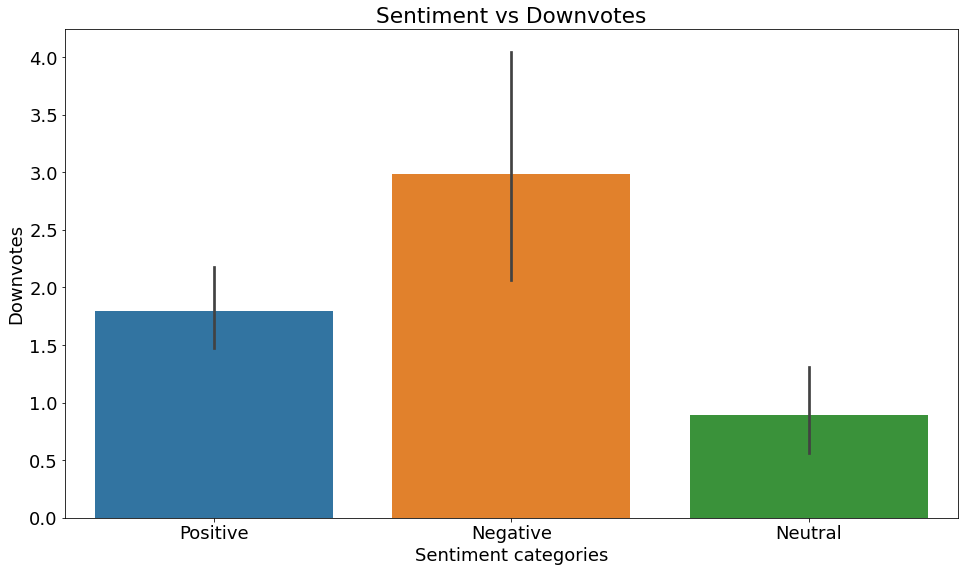

In [17]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'downvotes'])


#Plotting phase
sns.barplot( x=senti_help["sentiment"], y=senti_help["downvotes"])
plt.title('Sentiment vs Downvotes')
plt.xlabel('Sentiment categories')
plt.ylabel('Downvotes')
plt.show()

### Creating additional features for text analysis
Let's create polarity, review length and word count



In [18]:
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))


In [19]:
process_reviews.head()

product_id                                      product_title  \
0  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
1  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
2  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
3  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   
4  ACCFZGAQJGYCYDCM  BoAt Rockerz 235v2 with ASAP charging Version ...   

   rating       location          date  upvotes  downvotes  \
0       5        Shirala  8 months ago     1390        276   
1       5  Visakhapatnam  8 months ago      643        133   
2       5      Kozhikode     Feb, 2020     1449        328   
3       5          Jaora  7 months ago      160         28   
4       5      New Delhi  8 months ago      533        114   

                                             reviews sentiment  polarity  \
0  clarity good back hours thing fastest charging...  Positive  0.221429   
1  super sound good looking like prizeterrific pu...  Positive  0.477778   
2  much satisfied device price point awesome bran...  Positive  0.675000   
3  nice headphone bass good sound clear purchase ...  Positive  0.280000   
4  sound quality super battery backup super quali...  Positive  0.346667   

   review_len  word_count  
0         259          37  
1          52           7  
2         231          31  
3         175          27  
4         101          14

In [20]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Sentiment polarity distribution


In [21]:
process_reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

#### Insights:

We have a lot of positive polarities compared to the negative polarities

This polarity distributions assures the number of positive reviews we had.

We can say that this polarity is a normally distributed but not standard normal

### Review Rating Distribution
Looking into how overall ratings are distributed

In [22]:
process_reviews['rating'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')

#### We have a large number of 5 ratings(nearly 5.5k) followed by 4,3,1,2.

### Review Text Length Distribution
Length of review text

In [23]:
process_reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

#### We have a right skewed distribution where most of the lengths falls between 0-150

### Review Text Word Count Distribution
Word count of review text

In [24]:
process_reviews['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

#### We have a right skewed distribution with most of the words falling between 0-20 in a a review

### Bigram analysis
Here we will plot most frequent sequence of two words in reviews based on sentiments

In [25]:
## Get the bar chart from positive reviews ##
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]


## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

In [26]:
## Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')




# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

### Wordcloud-Positive reviews
Let's look at the word cloud of positive reviews

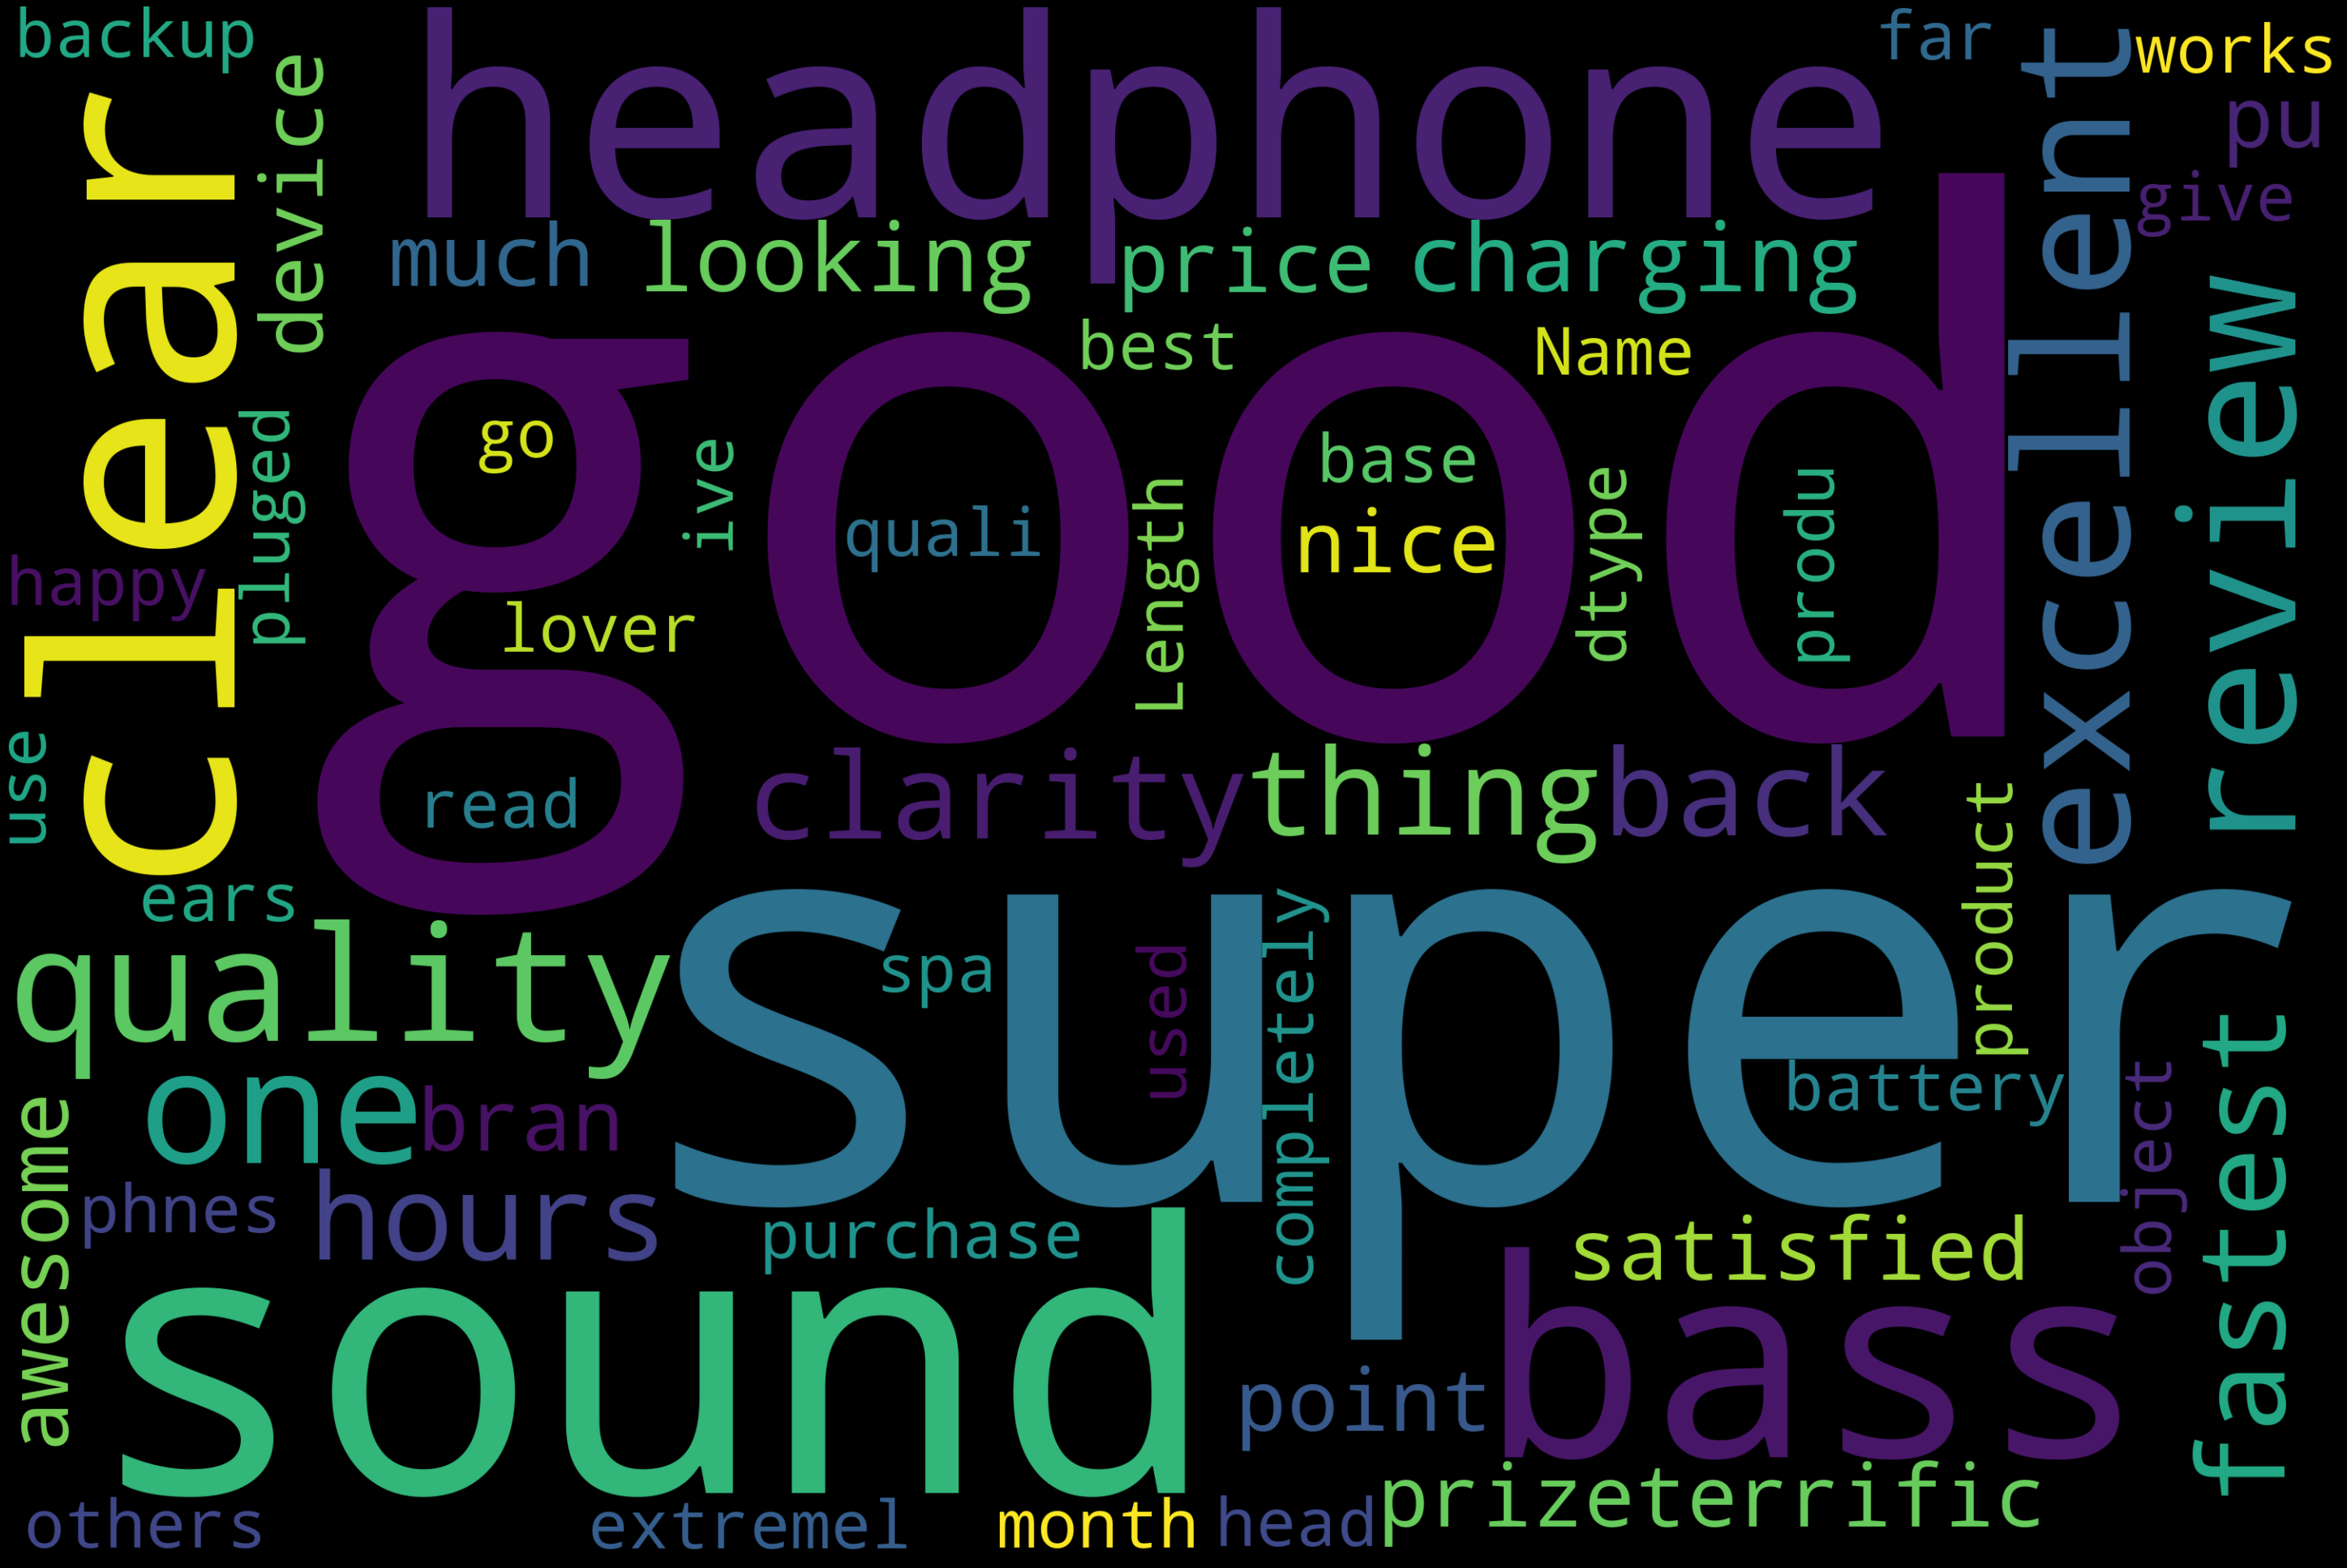

In [27]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### We can see positive words like great,affordable,expected,exactly etc.,

### Wordcloud-Neutral reviews
Let's look at the word cloud of neutral reviews

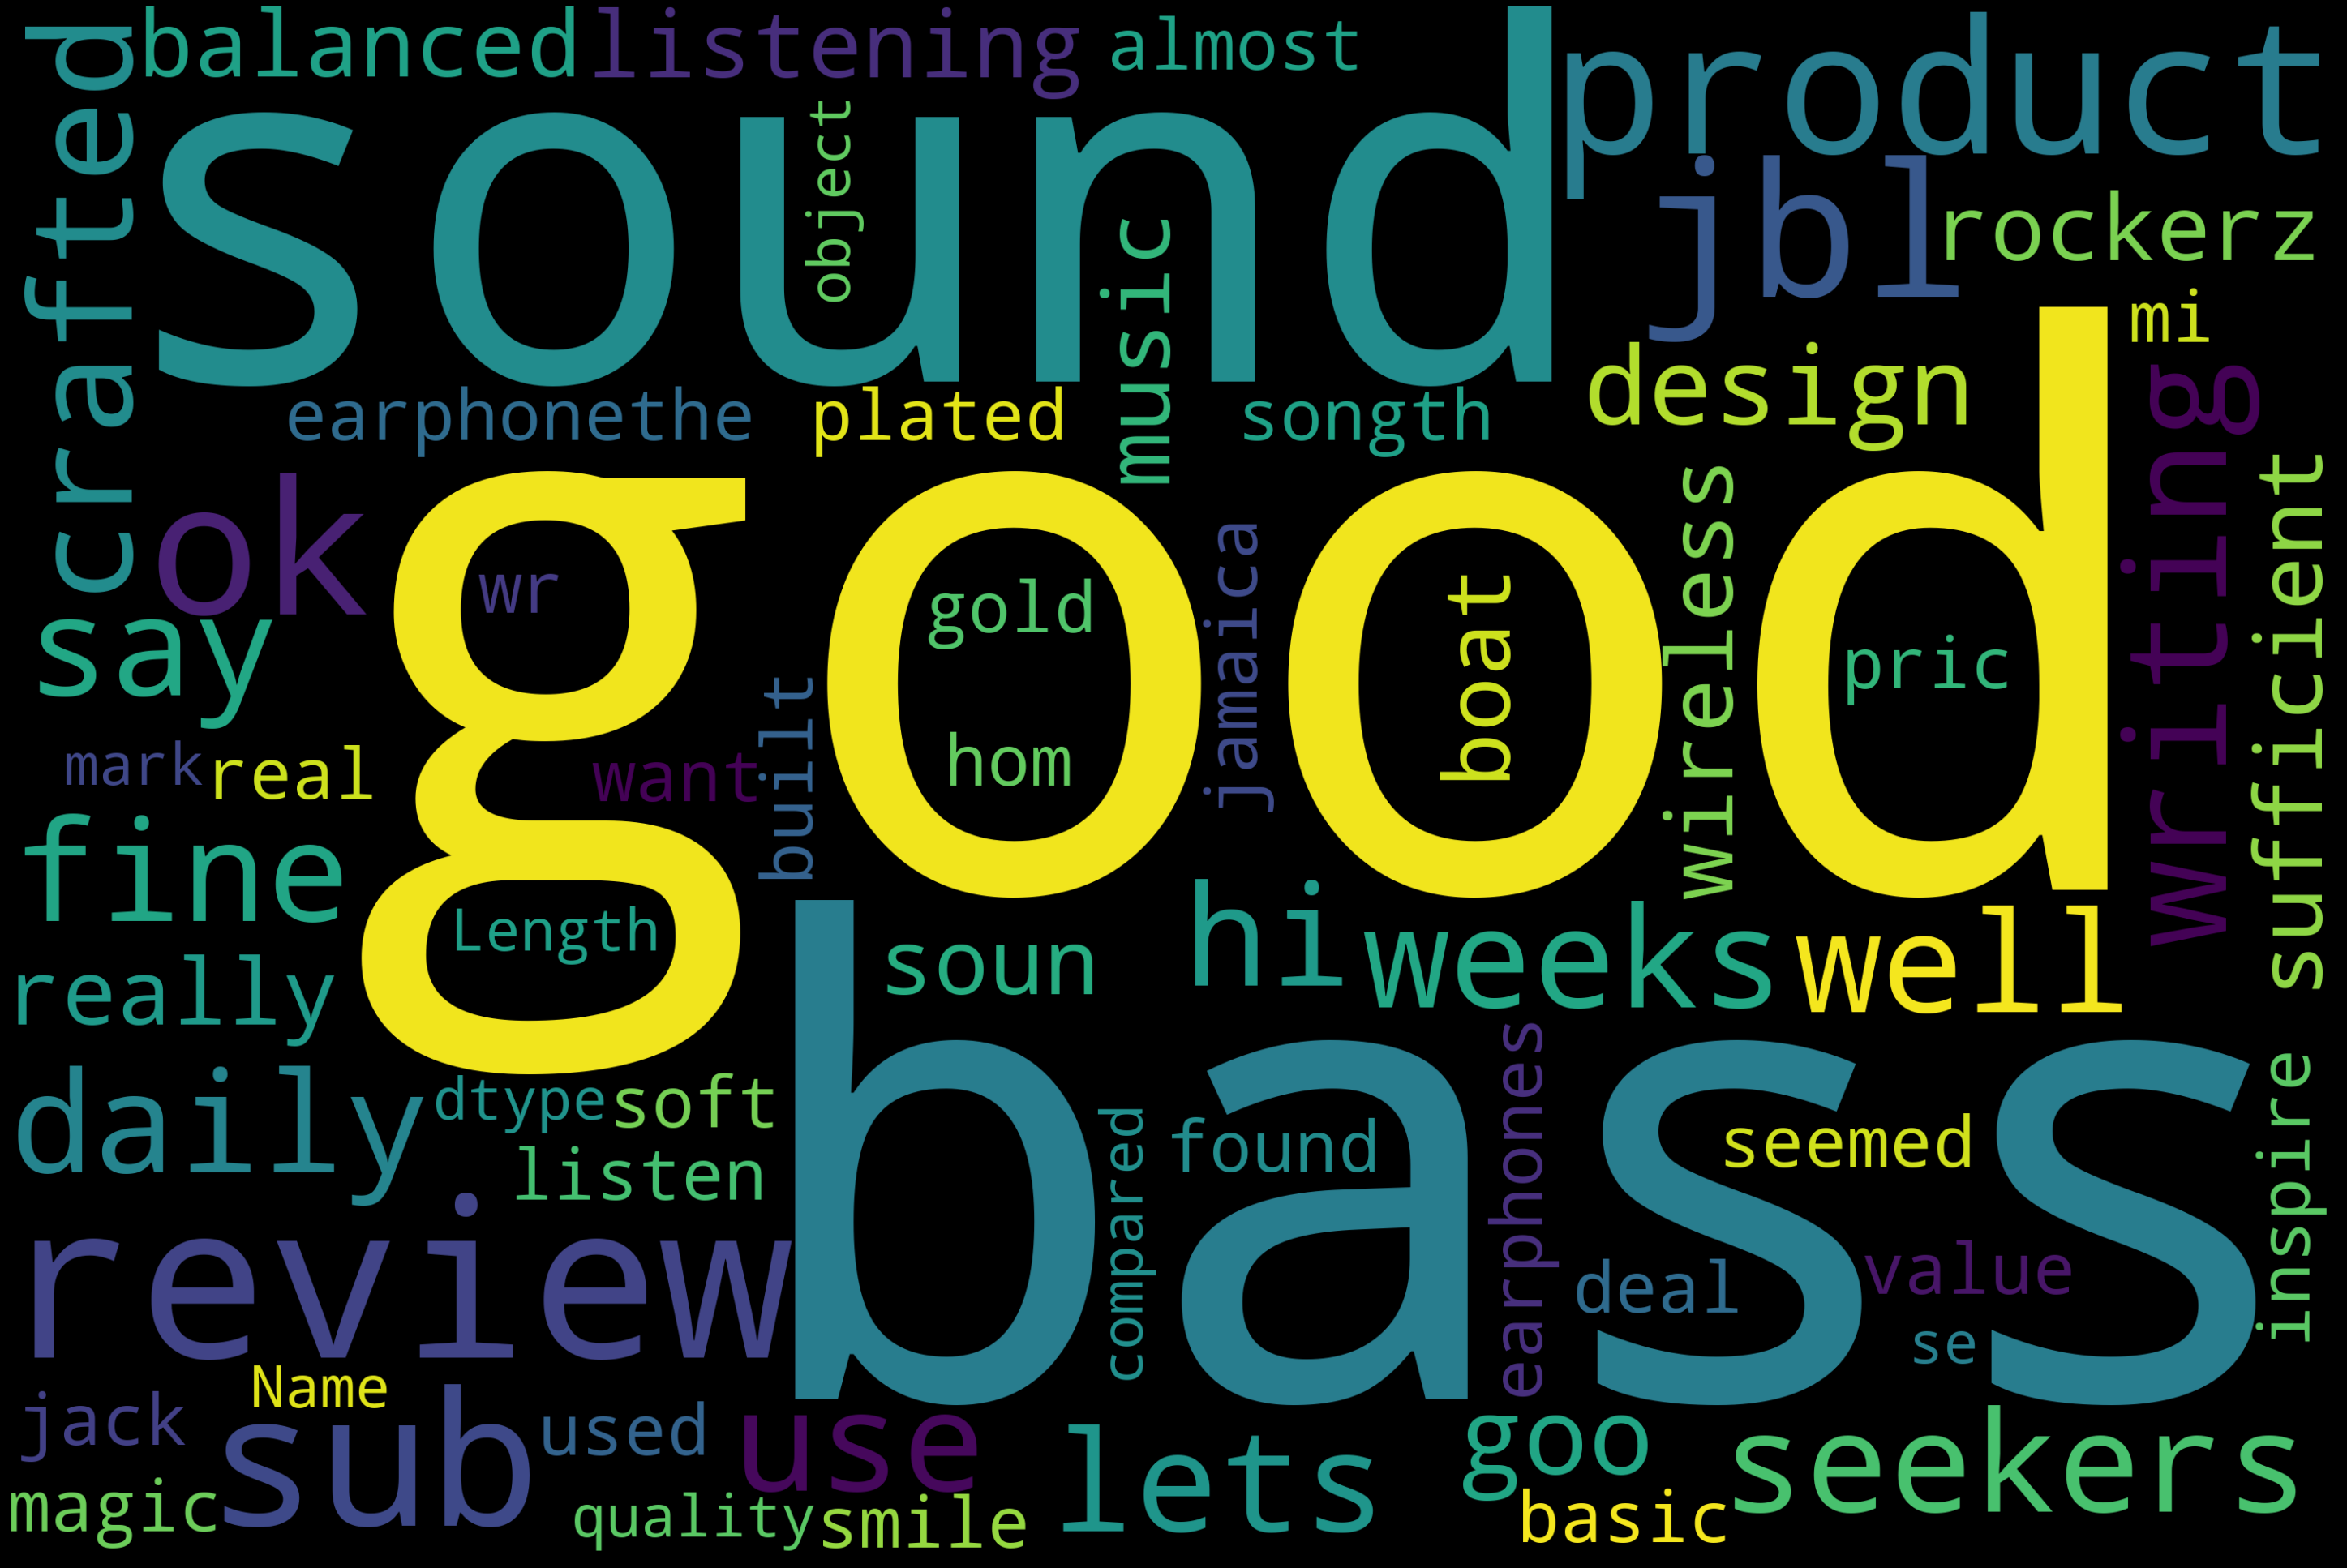

In [28]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Most of the neutral review words are focussed on the products and how can they be improved.

### Wordcloud-Negative reviews
Let's look at the word cloud of negative reviews

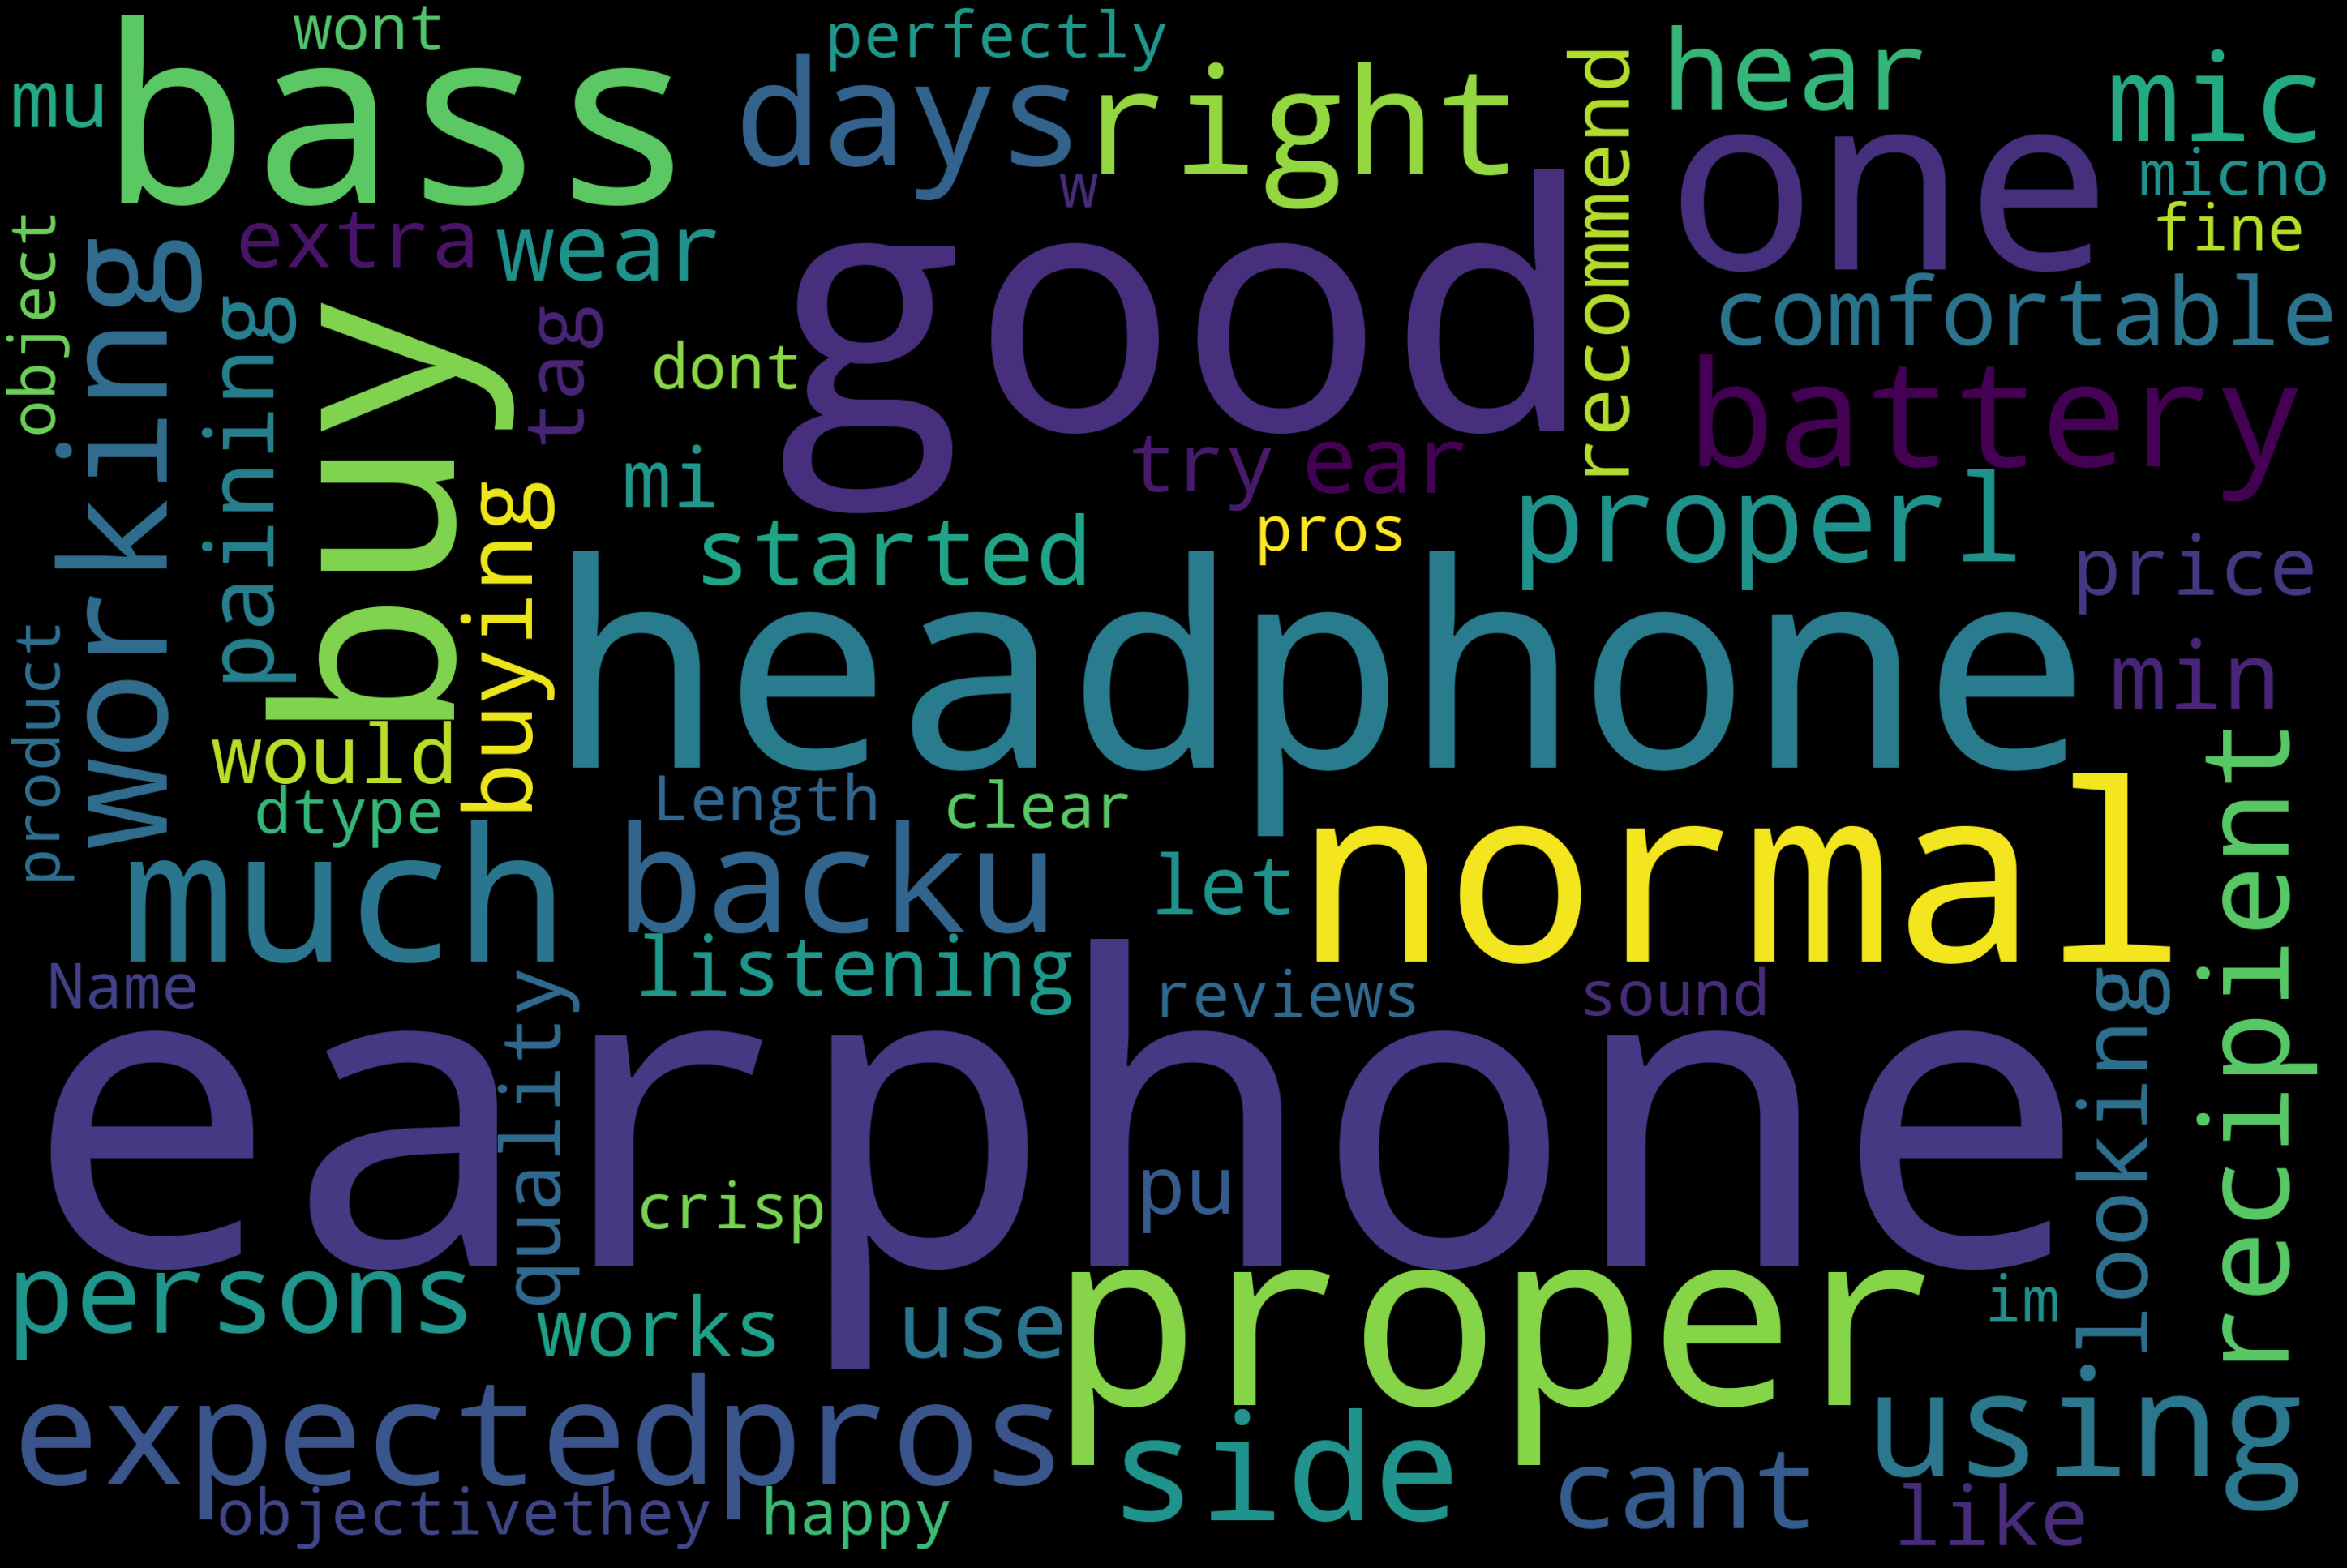

In [29]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### We can see negative review words such as dont,cant,paining, etc.,

### Extracting Features from Cleaned reviews
Before we build the model for our sentiment analysis, it is required to convert the review texts into vector formation as computer cannot understand words and their sentiment. In this project, we are going to use TF-TDF method to convert the texts

### Encoding target variable-sentiment
Let's encode our target variable with Label encoder.

In [30]:
# calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique() 

array([2, 0, 1])

In [31]:
process_reviews['sentiment'].value_counts()

2    7354
0    1398
1     622
Name: sentiment, dtype: int64

### Text Normalization - Stemming

In [53]:
# Stemming

#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  clarity good back hours thing fastest charging...
1  super sound good looking like prizeterrific pu...
2  much satisfied device price point awesome bran...
3  nice headphone bass good sound clear purchase ...
4  sound quality super battery backup super quali...

In [34]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review) 

In [35]:
corpus[1]

'super sound good look like prizeterrif purchas'

##### This is how a line looks like now, as computer cannot understand words and their sentiment we need to convert these words into 1's and 0's. To encode it we use TFIDF

### TFIDF(Term Frequency — Inverse Document Frequency)

Here we are splitting as bigram (two words) and consider their combined weight.Also we are taking only the top 5000 words from the reviews.

In [36]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [37]:
X.shape

(9374, 5000)

##### As we have considered 5000 words, we can confirm that we have 5000 columns from the shape.

In [38]:
#Getting the target variable(encoded)
y=process_reviews['sentiment']

In [39]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 7354, 0: 1398, 1: 622})
Resampled dataset shape Counter({2: 7354, 0: 7354, 1: 7354})


The resampled data has equally distributed classes

### Train-test-split (80 : 20)
Splitting the dataset into 80:20 ratio for train and test set respectively.

In [55]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=0)

### Building the model

In [56]:
# Defining a function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Building various models - using different algorithms:
1 - Logistic Regression

2 - Decision Tree

3 - KNN

4 -SVM

5- Naive Bayes





In [57]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("\n")
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))



Logistic Regression Test Accuracy: 0.8634519504929992


Decision Tree Test Accuracy: 0.8613185027750407


KNN Test Accuracy: 0.7638113745952353


SVC Test Accuracy: 0.8777461981144741


Naive Bayes Test Accuracy: 0.8233556261989337


### As we can see above, we got the highest accuracy for the SVM model. Now, we will look into the Hyperparameter tuning of SVM model

## Hyperparamter Tuning for SVM model

In the existing model - the default hyperparameter has the C value of 1, the gamma value of scale , and the kernel value of rbf 

### My experiments on the hyperparameters - for SVM Model

In [43]:
# KERNEL = 'rbf'

# Experiment 1 - { C= 1 , gamma = 1, kernel='rbf'}

svc = SVC(C=1, gamma = 1, kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Hyperparameters : C = 1 ; gamma = 1, kernel = rbf")
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))


Hyperparameters : C = 1 ; gamma = 1, kernel = rbf
Accuracy of SVM classifier on test set: 0.86


In [44]:
# Experiment 2 - { C= 1 , gamma = 2, kernel='rbf'} - Slightly increasing gamma

svc = SVC(C=1, gamma = 2, kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Hyperparameters : C = 1 ; gamma = 2, kernel = rbf")
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))


Hyperparameters : C = 1 ; gamma = 2, kernel = rbf
Accuracy of SVM classifier on test set: 0.86


In [45]:
# Experiment 3 - { C= 60 , gamma = 2, kernel='rbf'} - Increasing the value of C

svc = SVC(C=60, gamma = 2, kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Hyperparameters : C = 60 ; gamma = 2, kernel = rbf")
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))


Hyperparameters : C = 60 ; gamma = 2, kernel = rbf
Accuracy of SVM classifier on test set: 0.88


In [46]:
# Experiment 4 - { C= 100 , gamma = 1, kernel='rbf'} - Increasing the value of C

svc = SVC(C=36000, gamma = 10, kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Hyperparameters : C = 100 ; gamma = 1, kernel = rbf")
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))


Hyperparameters : C = 100 ; gamma = 1, kernel = rbf
Accuracy of SVM classifier on test set: 0.87


In [47]:
# KERNEL = 'poly'

# Experiment 5 - { C= 100 , degree = 2, kernel='poly'} - Increasing the value of C

svc = SVC(C=1000, degree = 1, kernel='poly')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Hyperparameters : C = 100 ; degree = 2, kernel = poly")
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))


Hyperparameters : C = 100 ; degree = 2, kernel = poly
Accuracy of SVM classifier on test set: 0.84


In [48]:
# KERNEL = 'poly'

# Experiment 5 - { C= 100 , degree = 2, kernel='poly'} - decreasing value of degree

svc = SVC(C=100, degree = 1, kernel='poly')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Hyperparameters : C = 100 ; degree = 1, kernel = poly")
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))


Hyperparameters : C = 100 ; degree = 1, kernel = poly
Accuracy of SVM classifier on test set: 0.83


In [49]:
# Linear kernel

# Experiment 5 - { C= 1 , gamma = 5, kernel='linear'} 

svc = SVC(C=10, kernel='rbf', gamma='auto')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Hyperparameters : C = 1 ; gamma = 5, kernel = linear")
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))

Hyperparameters : C = 1 ; gamma = 5, kernel = linear
Accuracy of SVM classifier on test set: 0.33


<span style="color:red">**From my above hyperparameter experiments ( In background I've run many experiments which is not mentioned here, I've picked the best ones among them) - the highest accuracy was obtained for the below hyperparams : { C= 60 , gamma = 2, kernel='rbf'}, { C= 60 , gamma = 2, kernel='rbf'}
    
I achieved accuracy of 0.88
Existing model accuracy = 0.877
A very slight increase in the accuracy**</span>

In [50]:
# Kernel - poly

svc = SVC(C=100, kernel='poly', degree=1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))

Accuracy of SVM classifier on test set: 0.83


In [51]:
poly_accuracy = svc.score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

NameError: name 'poly_pred' is not defined

In [ ]:
rbf_accuracy = svc.score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

In [ ]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
2